# 🧠 D&D Analytics: Optimization & Bias Correction

**Obiettivo:** Creare il modello predittivo definitivo per il Challenge Rating (CR).
**Metodologia:**
1.  **Data Refinement:** Estrazione di feature offensive dal testo e riduzione del dataset a 20 variabili chiave ("Lean").
2.  **Blindfold Tuning:** Utilizzo di un Random Forest con `max_features=0.3` per costringere il modello a considerare i Danni e non solo gli HP.

---


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Configurazione Grafica
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
print("✅ Librerie caricate.")


✅ Librerie caricate.


---------------------------------------------------------
SEZIONE 1: CARICAMENTO & DATA MINING (NLP)

---------------------------------------------------------
Carichiamo i dati grezzi ed estraiamo le informazioni offensive mancanti.


In [28]:
# 1. Caricamento
df_og = pd.read_csv("./data/monsters_og.csv")
df_final = pd.read_csv("./data/monsters_final.csv")
print(f"✅ Dataset caricati: OG {df_og.shape}, Final {df_final.shape}")

# 2. Sincronizzazione
min_len = min(len(df_og), len(df_final))
df_og = df_og.iloc[:min_len].reset_index(drop=True)
df_final = df_final.iloc[:min_len].reset_index(drop=True)
if 'name' not in df_final.columns: df_final['name'] = df_og['name']

# 3. NLP: Estrazione Danni
def extract_damage_potential(text):
    if not isinstance(text, str): return 0
    hits = re.findall(r'Hit:?\s*(\d+)', text, re.IGNORECASE)
    takes = re.findall(r'takes?\s*(\d+)\s+[\w\s]+damage', text, re.IGNORECASE)
    vals = [int(x) for x in hits + takes]
    return max(vals) if vals else 0

col_text = 'actions' if 'actions' in df_og.columns else 'special_abilities'
df_final['max_damage_per_hit'] = df_og[col_text].apply(extract_damage_potential)

# Stima conteggio azioni
if 'actions_count' not in df_final.columns:
    df_final['actions_count'] = df_og[col_text].apply(lambda x: str(x).count("'name':") if pd.notna(x) else 1)

# Feature Sintetica: "Minaccia Offensiva"
df_final['offensive_threat'] = df_final['max_damage_per_hit'] * df_final['actions_count'].fillna(1)
print("✅ Feature Engineering completato.")


✅ Dataset caricati: OG (2435, 71), Final (2435, 73)
✅ Feature Engineering completato.


---------------------------------------------------------
SEZIONE 2: CREAZIONE DATASET "LEAN" (Top 20)

---------------------------------------------------------
Selezioniamo solo le 20 feature più importanti per snellire il modello.


In [29]:
target = 'cr' if 'cr' in df_final.columns else 'challenge_rating'
X_all = df_final.select_dtypes(include=[np.number]).drop(columns=['Unnamed: 0', target, 'challenge_rating'], errors='ignore').fillna(0)
y_all = df_final[target]

# Calcolo Importanza Rapido
rf_sel = RandomForestRegressor(n_estimators=50, random_state=42)
rf_sel.fit(X_all, y_all)

# Selezione Top 20
feat_imp = pd.DataFrame({'Feature': X_all.columns, 'Importance': rf_sel.feature_importances_}).sort_values(by='Importance', ascending=False)
top_20 = feat_imp['Feature'].head(20).tolist()

# Creazione DataFrame Lean
cols = ['name'] + top_20 + [target]
df_lean = df_final[cols].copy()
if target != 'cr': df_lean.rename(columns={target: 'cr'}, inplace=True)

# Export
df_lean.to_csv("./data/monsters_lean.csv", index=False)
print(f"💾 Dataset salvato: './data/monsters_lean.csv' ({len(top_20)} feature + target)")


💾 Dataset salvato: './data/monsters_lean.csv' (20 feature + target)


---------------------------------------------------------
SEZIONE 3: BENCHMARK (Standard vs Tuned)

---------------------------------------------------------
 Confrontiamo il modello base con quello ottimizzato ("Blindfold Tuning").


In [30]:
# Setup
X = df_lean.drop(columns=['cr', 'name'], errors='ignore')
y = df_lean['cr']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. Modello STANDARD (Baseline)
print("🔴 Training Standard...")
rf_std = RandomForestRegressor(n_estimators=100, random_state=42)
rf_std.fit(X_train, y_train)

# 2. Modello TUNED (Blindfold - Soluzione Scelta)
# max_features=0.3 -> Ogni albero vede solo il 30% delle feature (nasconde spesso gli HP)
print("🟢 Training Tuned (Blindfold)...")
rf_tuned = RandomForestRegressor(
    n_estimators=300,
    max_features=0.3,
    min_samples_leaf=3,
    random_state=42,
    n_jobs=-1
)
rf_tuned.fit(X_train, y_train)
print("✅ Training completato.")


🔴 Training Standard...
🟢 Training Tuned (Blindfold)...
✅ Training completato.


---------------------------------------------------------
SEZIONE 4: FEATURE IMPORTANCE

---------------------------------------------------------
Analizziamo su cosa si basa il modello finale.


🔍 TOP 10 FEATURE:
                Feature  Importance
             hit_points    0.363650
         hit_dice_count    0.197208
           constitution    0.098288
            armor_class    0.074767
      constitution_save    0.067098
            wisdom_save    0.056877
legendary_actions_count    0.046013
     passive_perception    0.019245
       offensive_threat    0.016204
     max_damage_per_hit    0.015266


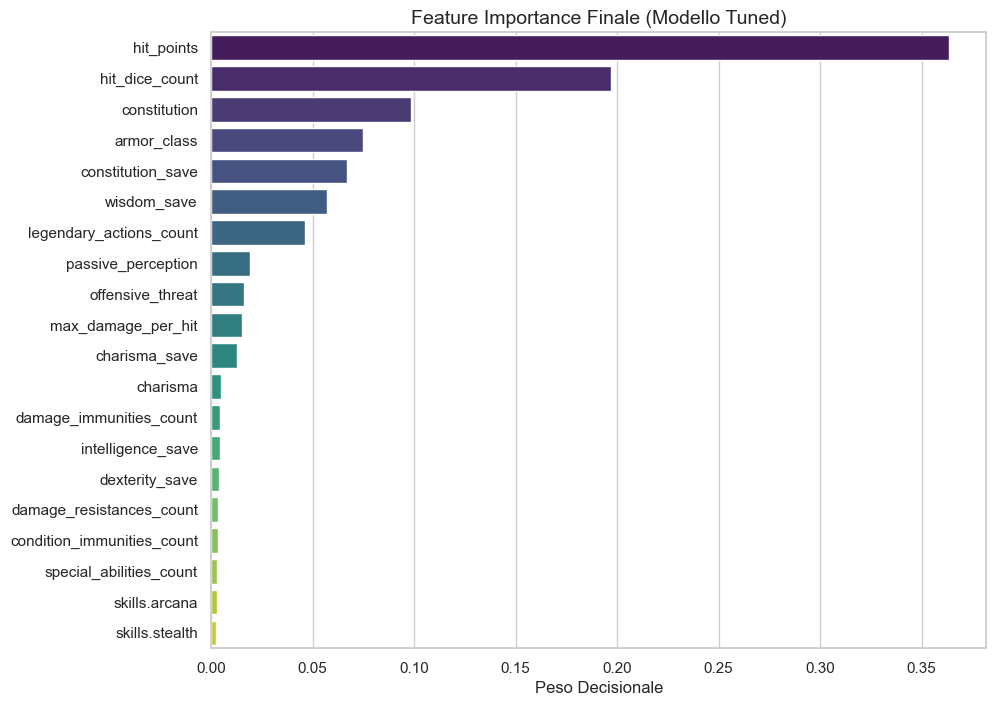

In [31]:
# Estrazione Importanza dal Modello Tuned
imp_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_tuned.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\n🔍 TOP 10 FEATURE:")
print(imp_df.head(10).to_string(index=False))

# Grafico Ordinato e Leggibile
plt.figure(figsize=(10, 8))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=imp_df, 
    palette='viridis', 
    order=imp_df['Feature'] # Fondamentale per l'ordine decrescente
)
plt.title('Feature Importance Finale (Modello Tuned)', fontsize=14)
plt.xlabel('Peso Decisionale', fontsize=12)
plt.ylabel('')
plt.show()


---
 5 Analisi comparativa

---

Confronto METRICHE (Chi è più preciso?)



🏆 TABELLA PERFORMANCE:
                     MAE    RMSE  R2 Score
Modello                                   
Standard (Prima)  0.8075  1.1774    0.9479
Tuned (Dopo)      0.8008  1.1387    0.9512


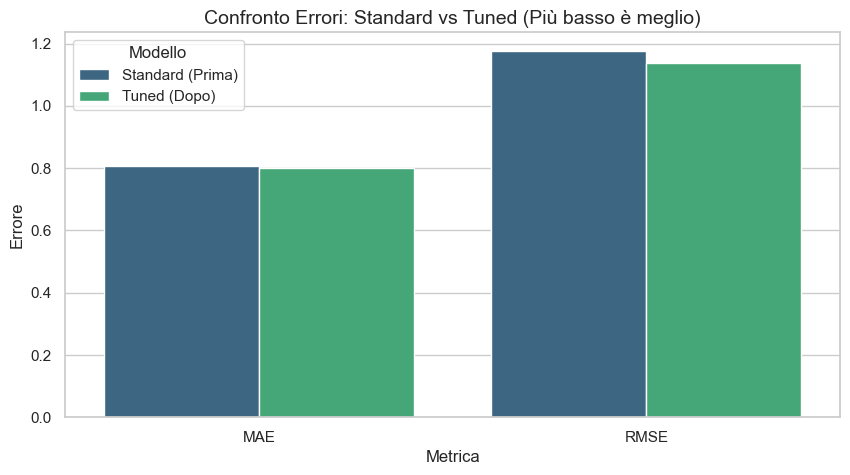

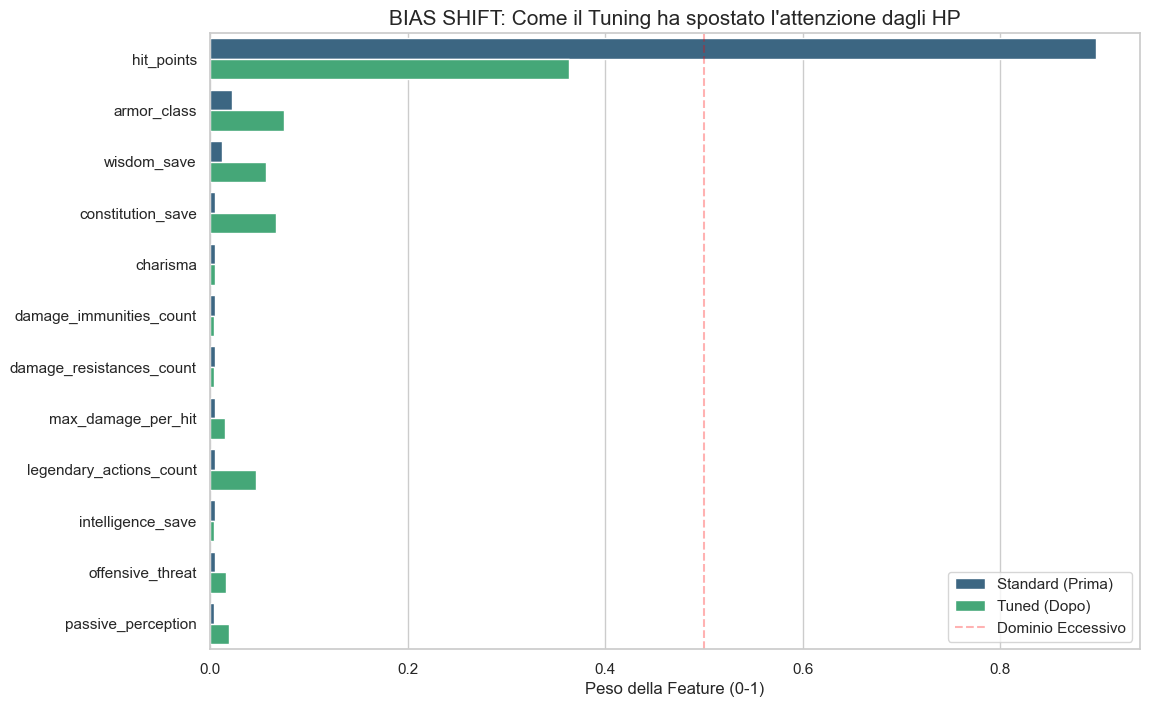

In [32]:

def get_metrics(model, X_t, y_t, label):
    pred = model.predict(X_t)
    return {
        "Modello": label,
        "MAE": mean_absolute_error(y_t, pred),
        "RMSE": np.sqrt(mean_squared_error(y_t, pred)),
        "R2 Score": r2_score(y_t, pred)
    }


res_std = get_metrics(rf_std, X_test, y_test, "Standard (Prima)")
res_tuned = get_metrics(rf_tuned, X_test, y_test, "Tuned (Dopo)")

df_res = pd.DataFrame([res_std, res_tuned]).set_index("Modello")
print("\n🏆 TABELLA PERFORMANCE:")
print(df_res.round(4))

# Grafico Errori (Barre Affiancate)
plt.figure(figsize=(10, 5))
res_melt = df_res.reset_index().melt(id_vars="Modello", value_vars=["MAE", "RMSE"], var_name="Metrica",
                                     value_name="Errore")
sns.barplot(data=res_melt, x="Metrica", y="Errore", hue="Modello", palette='viridis')
plt.title("Confronto Errori: Standard vs Tuned (Più basso è meglio)", fontsize=14)
plt.show()

# 2. Confronto LOGICA (Come è cambiato il ragionamento?)
# Creiamo un DataFrame unico per il grafico side-by-side
imp_std = pd.DataFrame({'Feature': X.columns, 'Importance': rf_std.feature_importances_, 'Modello': 'Standard (Prima)'})
imp_tuned = pd.DataFrame({'Feature': X.columns, 'Importance': rf_tuned.feature_importances_, 'Modello': 'Tuned (Dopo)'})

# Uniamo i due dati
comp_imp = pd.concat([imp_std, imp_tuned])

# Ordiniamo in base all'importanza nel modello Standard per vedere quanto cambia
order = imp_std.sort_values(by='Importance', ascending=False)['Feature'].head(12)  # Prendiamo le top 12

plt.figure(figsize=(12, 8))
sns.barplot(
    data=comp_imp[comp_imp['Feature'].isin(order)],  # Filtriamo solo le top feature
    y='Feature',
    x='Importance',
    hue='Modello',
    palette='viridis',
    order=order  # Manteniamo l'ordine deciso prima
)

plt.title("BIAS SHIFT: Come il Tuning ha spostato l'attenzione dagli HP", fontsize=15)
plt.xlabel("Peso della Feature (0-1)", fontsize=12)
plt.ylabel("")
plt.axvline(0.5, color='red', linestyle='--', alpha=0.3, label='Dominio Eccessivo')
plt.legend()
plt.show()

# Export Finale
df_lean.to_csv("./data/monsters_lean.csv", index=False)